In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [73]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

In [5]:
%store -r df

# Первая часть

В начале я пробовала использовать метрику RMSE (потом перешла на более удобную, но в начале несколько экспериментов с ней).

Также данные просто смешивались в куче и брались train_test_split.

Сначала бейзлайн:

In [11]:
easy_pred = [y_train.mean()] * len(y_test)
mean_squared_error(y_test, easy_pred, squared=False)

49.738082451167266

Теперь нормальные эксперименты:

In [6]:
all_columns = set(df.columns)
delete_columns = set(["StudLearnCount", "BachStudCount", "MagStudCount", "ID", "ProposalItem", "MasterItem", "MasterItemPos"])
categorical_columns = all_columns - delete_columns - set(["StudCount"])
numeric_columns = ["StudCount"]

X = df[np.array(all_columns - delete_columns)]
y = df["StudLearnCount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [43]:
def base_algo(numeric_col, categor_col, no_coef=False, method=Ridge(), error_func=mean_squared_error, params_for_error={}):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown='ignore'), categor_col),
        ('scaling', StandardScaler(), numeric_col)
    ])

    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', method)
    ])

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    err = error_func(y_test, y_pred, **params_for_error)
    print("Method:", method, "\n")
    print("Error:", error_func)
    print(err, "\n")
    if no_coef:
        return model
    coefs = model.named_steps['regression'].coef_
    print("Coefs:")
    for i in coefs:
        print(i)
    return model

In [44]:
base_algo(["StudCount"], [], params_for_error={"squared": False})

Method: Ridge() 

Error: <function mean_squared_error at 0x7fb247cb0f70>
31.971086371589404 

Coefs:
50.50413973703333


Pipeline(steps=[('ohe_and_scaling',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  []),
                                                 ('scaling', StandardScaler(),
                                                  ['StudCount'])])),
                ('regression', Ridge())])

Пробуем добавить еще признаков:

In [50]:
base_algo(["StudCount"], ["WithOnlineCourse", "ItemLearnYear_D"], params_for_error={"squared": False})

Method: Ridge() 

Error: <function mean_squared_error at 0x7f0f48e83c10>
31.932715768073177 

Coefs:
-1.16538917977444
1.1653891797746563
3.433978418364064
0.12656693297664046
-3.560545351314346
50.55441420135785


Давайте попробуем поиспользовать Credits и PracticeHours, но для этого надо решить, что делать с проблеми ("None").
Для Credits проблема решена выше - заменили на 0 (это в основном физкультура, логично, что она не имеет веса).
Предлагаю для PracticeHours и тд тоже заменить на 0 и потестить.

In [51]:
base_algo(["StudCount", "Credits"], ["WithOnlineCourse", "ItemLearnYear_D"], params_for_error={"squared": False})

Method: Ridge() 

Error: <function mean_squared_error at 0x7f0f48e83c10>
31.961100948837455 

Coefs:
-1.2970410973180722
1.297041097318243
3.4138668894503965
0.13247811247546215
-3.546345001899121
50.56245034942134
-0.790465323570226


Видно, что самые большие дельты у Английского языка(в том или ином виде). Давайте попробуем добавить факультет:

In [52]:
base_algo(["StudCount", "Credits"], ["Description"], no_coef=True, params_for_error={"squared": False})

Method: Ridge() 

Error: <function mean_squared_error at 0x7f0f48e83c10>
32.30016017583393 



In [53]:
base_algo(["StudCount"], ["EdLevel_D", "ItemCourse_D"], no_coef=True, params_for_error={"squared": False})

Method: Ridge() 

Error: <function mean_squared_error at 0x7f0f48e83c10>
31.053559446075898 



In [54]:
base_algo(
    ["StudCount"],
    ["EdLevel_D", "ItemCourse_D", "ItemLearnYear_D"],
    no_coef=True, params_for_error={"squared": False})

Method: Ridge() 

Error: <function mean_squared_error at 0x7f0f48e83c10>
31.008989943556177 



Дрбавили так называемые "корзины" - взяли логарифм от StudCount, чтобы разделть веса на тяжелые и легкие.

In [55]:
base_algo(
    ["StudCount"],
    ["StudCountBins"],
    no_coef=False, params_for_error={"squared": False})

Method: Ridge() 

Error: <function mean_squared_error at 0x7f0f48e83c10>
33.171345666821814 

Coefs:
84.34209905100354
24.302301578900092
26.274534771643047
29.059015854428985
41.13867161635022
75.84951459548952
180.66621236453105
-513.7592892245956
52.12693939008375
48.532050178995924


Пробуем простое решающее дерево и градиентный бустинг:

In [58]:
base_algo(
    ["StudCount"],
    ["EdLevel_D", "ItemCourse_D", "ItemLearnYear_D"],
    method=DecisionTreeRegressor(),
    no_coef=True, params_for_error={"squared": False})

Method: DecisionTreeRegressor() 

Error: <function mean_squared_error at 0x7f0f48e83c10>
70.78357889472663 



In [60]:
base_algo(
    ["StudCount", "EntireHours"],
    ["EdLevel_D", "ItemCourse_D", "ItemLearnYear_D", "StudCountBins", "WithOnlineCourse"],
    method=GradientBoostingRegressor(),
    no_coef=True, params_for_error={"squared": False})

Method: GradientBoostingRegressor() 

Error: <function mean_squared_error at 0x7f0f48e83c10>
37.65608950346666 



# Вторая часть

Пробуем изменить метрику на процент ошибки относительно правильного ответа:

In [12]:
def part_error(y_test, y_pred):
    y_test[y_test == 0] = 1
    res = y_pred / y_test
    res = abs(1 - res)
    return res.mean()

In [69]:
base_algo(
    ["StudCount"],
    [],
    error_func=part_error)

Method: Ridge() 

Error: <function part_error at 0x7f0f40fbce50>
2.995311588933207 

Coefs:
50.50413973703333


In [27]:
base_algo(
    ["StudCount"],
    ["EdLevel_D", "ItemCourse_D", "ItemLearnYear_D"],
    error_func=part_error,
)

Method: Ridge() 

Error: <function part_error at 0x7fb244515a60>
2.6387213237249103 

Coefs:
-26.748007361766742
28.99335153415839
-10.402182077920306
8.156837904394441
26.782201477548085
-12.564997619108984
-13.021354944102995
-14.702651190570625
-15.195752989706099
-16.577126259194642
18.838381921122853
18.28446169985428
3.8943215609773536
4.262516343417086
3.7447551689806344
-0.25333504187391975
-3.4914201270610064
46.90796251311258


Прочитала про метрику SMAPE:

In [1]:
def smape(A, F):
    return np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F))) / len(A)

Также я прочитала, что если мы берем в качестве регуляризатора L1, то часто много весов зануляется. Глобально, мы этого и хотим - положить кучу разных данных и занулить их потом. Так что попробуем поиспользовать Lasso:

In [10]:
from sklearn.linear_model import Lasso

In [14]:
base_algo(
    numeric_col=["StudCount"],
    categor_col=[],
    method=Lasso(),
    error_func=part_error)

Method: Lasso() 

Error: <function part_error at 0x7fb244515a60>
3.0483246017438477 

Coefs:
49.507908140237134


In [15]:
base_algo(
    numeric_col=["StudCount"],
    categor_col=["EdLevel_D", "ItemCourse_D", "ItemLearnYear_D"],
    method=Lasso(),
    error_func=part_error)

Method: Lasso() 

Error: <function part_error at 0x7fb244515a60>
2.8209659134220844 

Coefs:
-5.740088905505539
8.454213789759486
-0.0
0.0
10.633986327516785
0.0
-0.0
-0.0
-0.0
-0.0
0.0
-0.0
0.0
0.0
0.31323208758413995
0.0
-0.6445818597535079
47.966927615745604


In [17]:
base_algo(
    numeric_col=["StudCount"],
    categor_col=["EdLevel_D", "ItemCourse_D", "ItemLearnYear_D"],
    method=Lasso(alpha=0.5),
    error_func=part_error)

Method: Lasso(alpha=0.5) 

Error: <function part_error at 0x7fb244515a60>
2.696341775810879 

Coefs:
-24.21674679831957
8.281107759482296
-0.0
0.0
23.06672724930179
0.0
-0.0
-0.0
-0.0
-0.0
0.0
0.0
0.0
0.0
2.0824702469536533
0.0
-1.9401214094825177
47.552979588987974


In [22]:
df.dtypes

ID                             int64
ProposalItem                   int64
PlanClass_D                   object
EdLevel_D                     object
ItemCourse_D                  object
ItemLearnYear_D               object
StudCount                      int64
StudLearnCount                 int64
BachStudCount                  int64
MagStudCount                   int64
RegDepartment_D               object
Faculty_D                     object
LearnProgram_D                object
Description                   object
LongName                      object
SubjectClass_D                object
FacDepartment_D               object
FDFaculty_D                   object
FDRegDepartment_D             object
MasterItem                     int64
MasterItemPos                 object
ItemSource_D                  object
AudienceScope_D               object
Credits                        int64
EntireHours                    int64
LectionHours                   int64
SeminarHours                   int64
P

In [33]:
base_algo(
    numeric_col=["StudCount", "Credits", "EntireHours", "LectionHours", "SeminarHours", "PracticeHours"],
    categor_col=["PlanClass_D", "EdLevel_D", "ItemCourse_D", "ItemLearnYear_D", "PeriodNumList", "WithOnlineCourse"],
    method=Lasso(alpha=0.5),
    error_func=part_error)

Method: Lasso(alpha=0.5) 

Error: <function part_error at 0x7fb244515a60>
2.763400044181575 

Coefs:
0.0
0.0
-0.0
-10.273457948596782
-21.564376331170905
8.748725423121488
-0.0
0.0
10.756191294443562
0.0
0.0
-0.0
-0.3586826347611377
-0.0
0.0
0.0
0.0
0.0
1.1399056517268444
-0.0
-1.8894702394244856
-0.0
0.0
-0.0
0.0
0.0
-0.0
0.0
-0.0
0.0
-0.0
0.0
-0.0
-0.0
-0.0
212.81772248264016
-0.0
0.0
47.66407428773121
0.0
0.0
0.07777515234035015
0.006440698895365199
-0.7289882238825414


## Перейдем на SMAPE:

In [34]:
base_algo(
    numeric_col=["StudCount"],
    categor_col=[],
    method=Lasso(),
    error_func=smape)

Method: Lasso() 

Error: <function smape at 0x7fb28835a430>
0.6181089596732408 

Coefs:
49.507908140237134


In [35]:
base_algo(
    numeric_col=["StudCount"],
    categor_col=["EdLevel_D", "ItemCourse_D", "ItemLearnYear_D"],
    method=Lasso(),
    error_func=smape)

Method: Lasso() 

Error: <function smape at 0x7fb28835a430>
0.6056611867156406 

Coefs:
-5.740088905505539
8.454213789759486
-0.0
0.0
10.633986327516785
0.0
-0.0
-0.0
-0.0
-0.0
0.0
-0.0
0.0
0.0
0.31323208758413995
0.0
-0.6445818597535079
47.966927615745604


In [36]:
base_algo(
    numeric_col=["StudCount"],
    categor_col=["EdLevel_D", "ItemCourse_D", "ItemLearnYear_D"],
    method=Lasso(alpha=0.5),
    error_func=smape)

Method: Lasso(alpha=0.5) 

Error: <function smape at 0x7fb28835a430>
0.6069783290833942 

Coefs:
-24.21674679831957
8.281107759482296
-0.0
0.0
23.06672724930179
0.0
-0.0
-0.0
-0.0
-0.0
0.0
0.0
0.0
0.0
2.0824702469536533
0.0
-1.9401214094825177
47.552979588987974


In [37]:
base_algo(
    numeric_col=["StudCount", "Credits", "EntireHours", "LectionHours", "SeminarHours", "PracticeHours"],
    categor_col=["PlanClass_D", "EdLevel_D", "ItemCourse_D", "ItemLearnYear_D", "PeriodNumList", "WithOnlineCourse"],
    method=Lasso(alpha=0.5),
    error_func=smape)

Method: Lasso(alpha=0.5) 

Error: <function smape at 0x7fb28835a430>
0.6048528990263804 

Coefs:
0.0
0.0
-0.0
-10.273457948596782
-21.564376331170905
8.748725423121488
-0.0
0.0
10.756191294443562
0.0
0.0
-0.0
-0.3586826347611377
-0.0
0.0
0.0
0.0
0.0
1.1399056517268444
-0.0
-1.8894702394244856
-0.0
0.0
-0.0
0.0
0.0
-0.0
0.0
-0.0
0.0
-0.0
0.0
-0.0
-0.0
-0.0
212.81772248264016
-0.0
0.0
47.66407428773121
0.0
0.0
0.07777515234035015
0.006440698895365199
-0.7289882238825414


Попробуем DecisionTreeRegressor (с визуалиазацией):

In [45]:
base_algo(
    numeric_col=["StudCount", "Credits", "EntireHours", "LectionHours", "SeminarHours", "PracticeHours"],
    categor_col=["PlanClass_D", "EdLevel_D", "ItemCourse_D", "ItemLearnYear_D", "PeriodNumList", "WithOnlineCourse"],
    method=DecisionTreeRegressor(),
    no_coef=True,
    error_func=smape)

Method: DecisionTreeRegressor() 

Error: <function smape at 0x7fb28835a430>
0.6352356241191554 



Pipeline(steps=[('ohe_and_scaling',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['PlanClass_D', 'EdLevel_D',
                                                   'ItemCourse_D',
                                                   'ItemLearnYear_D',
                                                   'PeriodNumList',
                                                   'WithOnlineCourse']),
                                                 ('scaling', StandardScaler(),
                                                  ['StudCount', 'Credits',
                                                   'EntireHours',
                                                   'LectionHours',
                                                   'SeminarHours',
                                                   'PracticeHours'])])),
                ('regression', DecisionTreeRegressor())])

In [42]:
from sklearn import tree

In [54]:
model_tree = base_algo(
    numeric_col=["StudCount"],
    categor_col=[],
    method=DecisionTreeRegressor(),
    no_coef=True,
    error_func=smape)

Method: DecisionTreeRegressor() 

Error: <function smape at 0x7fb28835a430>
0.5833954238013328 



In [57]:
model_tree = base_algo(
    numeric_col=["StudCount"],
    categor_col=[],
    method=DecisionTreeRegressor(criterion="absolute_error"),
    no_coef=True,
    error_func=smape)

Method: DecisionTreeRegressor(criterion='absolute_error') 

Error: <function smape at 0x7fb28835a430>
0.5715934552496578 



In [58]:
model_tree = base_algo(
    numeric_col=["StudCount"],
    categor_col=[],
    method=DecisionTreeRegressor(criterion="absolute_error", max_depth=3),
    no_coef=True,
    error_func=smape)

Method: DecisionTreeRegressor(criterion='absolute_error', max_depth=3) 

Error: <function smape at 0x7fb28835a430>
0.601072193127812 



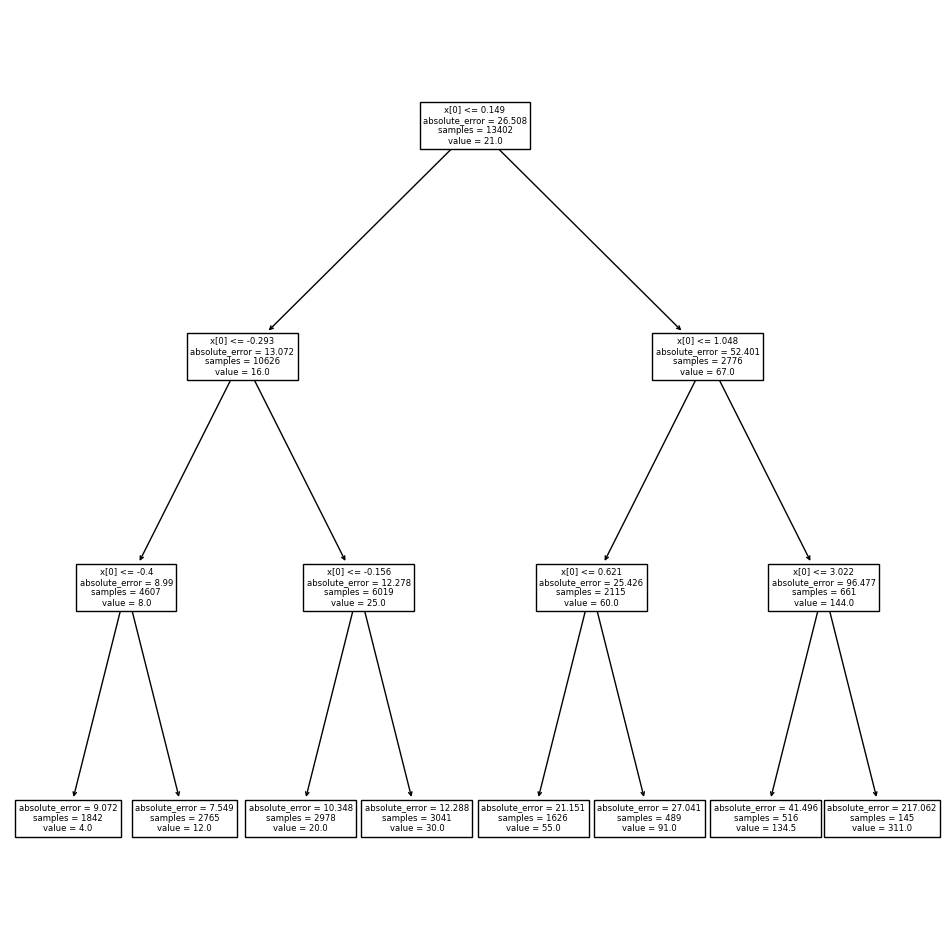

In [63]:
plt.figure(figsize=(12, 12))
tree.plot_tree(model_tree.named_steps['regression'])
plt.show()

In [67]:
model_tree = base_algo(
    numeric_col=["StudCount"],
    categor_col=["PlanClass_D", "EdLevel_D", "ItemCourse_D"],
    method=DecisionTreeRegressor(criterion="absolute_error"),
    no_coef=True,
    error_func=smape)

Method: DecisionTreeRegressor(criterion='absolute_error') 

Error: <function smape at 0x7fb28835a430>
0.5658210143509778 



In [68]:
model_tree = base_algo(
    numeric_col=["StudCount", "Credits", "EntireHours", "LectionHours", "SeminarHours", "PracticeHours"],
    categor_col=["PlanClass_D", "EdLevel_D", "ItemCourse_D", "ItemLearnYear_D", "PeriodNumList", "WithOnlineCourse"],
    method=DecisionTreeRegressor(criterion="absolute_error"),
    no_coef=True,
    error_func=smape)

Method: DecisionTreeRegressor(criterion='absolute_error') 

Error: <function smape at 0x7fb28835a430>
0.6329233134314386 



In [74]:
model_tree = base_algo(
    numeric_col=["StudCount", "Credits", "EntireHours", "LectionHours", "SeminarHours", "PracticeHours"],
    categor_col=["PlanClass_D", "EdLevel_D", "ItemCourse_D", "ItemLearnYear_D", "PeriodNumList", "WithOnlineCourse"],
    method=RandomForestRegressor(criterion="absolute_error"),
    no_coef=True,
    error_func=smape)

Method: RandomForestRegressor(criterion='absolute_error') 

Error: <function smape at 0x7fb28835a430>
0.5687225560106784 



In [77]:
df.nunique()

ID                            19147
ProposalItem                  16826
PlanClass_D                       4
EdLevel_D                         4
ItemCourse_D                     10
ItemLearnYear_D                   3
StudCount                       269
StudLearnCount                  375
BachStudCount                   372
MagStudCount                    127
RegDepartment_D                   5
Faculty_D                        52
LearnProgram_D                  295
Description                    7087
LongName                       7089
SubjectClass_D                    2
FacDepartment_D                 210
FDFaculty_D                      53
FDRegDepartment_D                 4
MasterItem                    16170
MasterItemPos                 16164
ItemSource_D                      4
AudienceScope_D                   4
Credits                          24
EntireHours                      30
LectionHours                     59
SeminarHours                     73
PracticeHours               

In [79]:
100 - 16826 / 19147 * 100

12.122003447015189